In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
# !rm -r /content/kaggle_3m

In [ ]:
# !rm -r /content/lgg-mri-segmentation

In [ ]:
# !rm -r /content/lgg-mri-segmentation.zip

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"tejavathtejaveeru","key":"86de316a2eac975fd23d862929c8143a"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !pip install kaggle

In [ ]:
# !kaggle competitions download -c uw-madison-gi-tract-image-segmentation
# kaggle competitions download -c uw-madison-gi-tract-image-segmentation
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 697M/714M [00:04<00:00, 229MB/s]
100% 714M/714M [00:04<00:00, 176MB/s]


In [ ]:
# !unzip /content/uw-madison-gi-tract-image-segmentation.zip -d /content/data
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
# # importing the zipfile module
# from zipfile import ZipFile
  
# # loading the temp.zip and creating a zip object
# with ZipFile("/content/uw-madison-gi-tract-image-segmentation.zip", 'r') as zObject:
  
#     # Extracting all the members of the zip 
#     # into a specific location.
#     zObject.extractall(path="/content/data")

In [ ]:
# img_data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
# img_data = pd.read_csv('/content/data/train.csv')
img_data = pd.read_csv('/content/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
img_data.shape

(110, 18)

In [ ]:
data_path = []
# for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
# for sub_dir_path in glob.glob("/content/data/train/*/"+"*"):
for sub_dir_path in glob.glob("/content/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/content/kaggle_3m/README.md'


In [ ]:
data_path

['TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_35.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_16_mask.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_38_mask.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_48.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_36_mask.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26_mask.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_16.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33.tif',
 'TCGA_DU_7013_19860523',
 '/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_701

In [ ]:
filenames = data_path[::2]
masks = data_path[1::2]

In [ ]:
# filenames , masks

In [ ]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
df

,patient_id,img_path
0,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
1,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
2,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
3,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
4,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
...,...,...
7853,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
7854,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
7855,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
7856,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...


In [ ]:
original_img     = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [ ]:
original_img,mask_img

(                 patient_id                                           img_path
 0     TCGA_DU_7013_19860523  /content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
 3     TCGA_DU_7013_19860523  /content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
 4     TCGA_DU_7013_19860523  /content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
 7     TCGA_DU_7013_19860523  /content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
 8     TCGA_DU_7013_19860523  /content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
 ...                     ...                                                ...
 7844  TCGA_HT_7693_19950520  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
 7846  TCGA_HT_7693_19950520  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
 7851  TCGA_HT_7693_19950520  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
 7855  TCGA_HT_7693_19950520  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
 7856  TCGA_HT_7693_19950520  /content/kaggle_3m/TCGA_HT_7693_19950520/TCGA_...
 
 [3929 rows x 2 columns],
            

In [ ]:
# imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[89:-4]))
# masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[63:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[63:-9]))
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50.tif 
Mask path: /content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50_mask.tif


In [ ]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...
1,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...
2,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_HT_7692_19960724/TCGA_...,/content/kaggle_3m/TCGA_HT_7692_19960724/TCGA_...
3,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7018_19911220/TCGA_...,/content/kaggle_3m/TCGA_DU_7018_19911220/TCGA_...
4,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_5853_19950823/TCGA_...,/content/kaggle_3m/TCGA_DU_5853_19950823/TCGA_...
...,...,...,...
3924,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...
3925,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
3926,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...
3927,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...


In [ ]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [ ]:
# from google.colab.patches import cv2_imshow
# a = cv2.imread('/content/data/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9.tif')
# cv2_imshow(a)
# b = cv2.imread('/content/data/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9_mask.tif')
# cv2_imshow(b)

In [ ]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))
mri_df

,patient_id,img_path,mask_path,mask
0,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,0
1,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...,/content/kaggle_3m/TCGA_HT_7605_19950916/TCGA_...,0
2,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_HT_7692_19960724/TCGA_...,/content/kaggle_3m/TCGA_HT_7692_19960724/TCGA_...,0
3,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_7018_19911220/TCGA_...,/content/kaggle_3m/TCGA_DU_7018_19911220/TCGA_...,0
4,TCGA_DU_7013_19860523,/content/kaggle_3m/TCGA_DU_5853_19950823/TCGA_...,/content/kaggle_3m/TCGA_DU_5853_19950823/TCGA_...,0
...,...,...,...,...
3924,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3925,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3927,TCGA_HT_7693_19950520,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


In [ ]:
mri_df.drop(columns=['patient_id'],inplace=True)

In [ ]:
mri_train, mri_test = train_test_split(mri_df,test_size = 0.1)
mri_train, mri_val = train_test_split(mri_train,test_size = 0.2)

print('Training data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
print('Validation data shape is {0}'.format(mri_val.values.shape))

mri_train.sample(n=5)

Training data shape is (2828, 3)
Test data shape is (393, 3)
Validation data shape is (708, 3)


,img_path,mask_path,mask
1332,/content/kaggle_3m/TCGA_HT_7602_19951103/TCGA_...,/content/kaggle_3m/TCGA_HT_7602_19951103/TCGA_...,0
1760,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,/content/kaggle_3m/TCGA_DU_7013_19860523/TCGA_...,1
395,/content/kaggle_3m/TCGA_HT_7877_19980917/TCGA_...,/content/kaggle_3m/TCGA_HT_7877_19980917/TCGA_...,0
1300,/content/kaggle_3m/TCGA_DU_6407_19860514/TCGA_...,/content/kaggle_3m/TCGA_DU_6407_19860514/TCGA_...,0
403,/content/kaggle_3m/TCGA_DU_7010_19860307/TCGA_...,/content/kaggle_3m/TCGA_DU_7010_19860307/TCGA_...,0


<Axes: title={'center': 'Count of Tumour vs No Tumour'}>

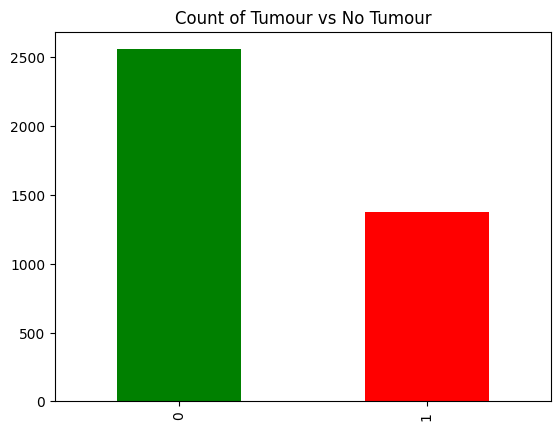

In [ ]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [ ]:
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

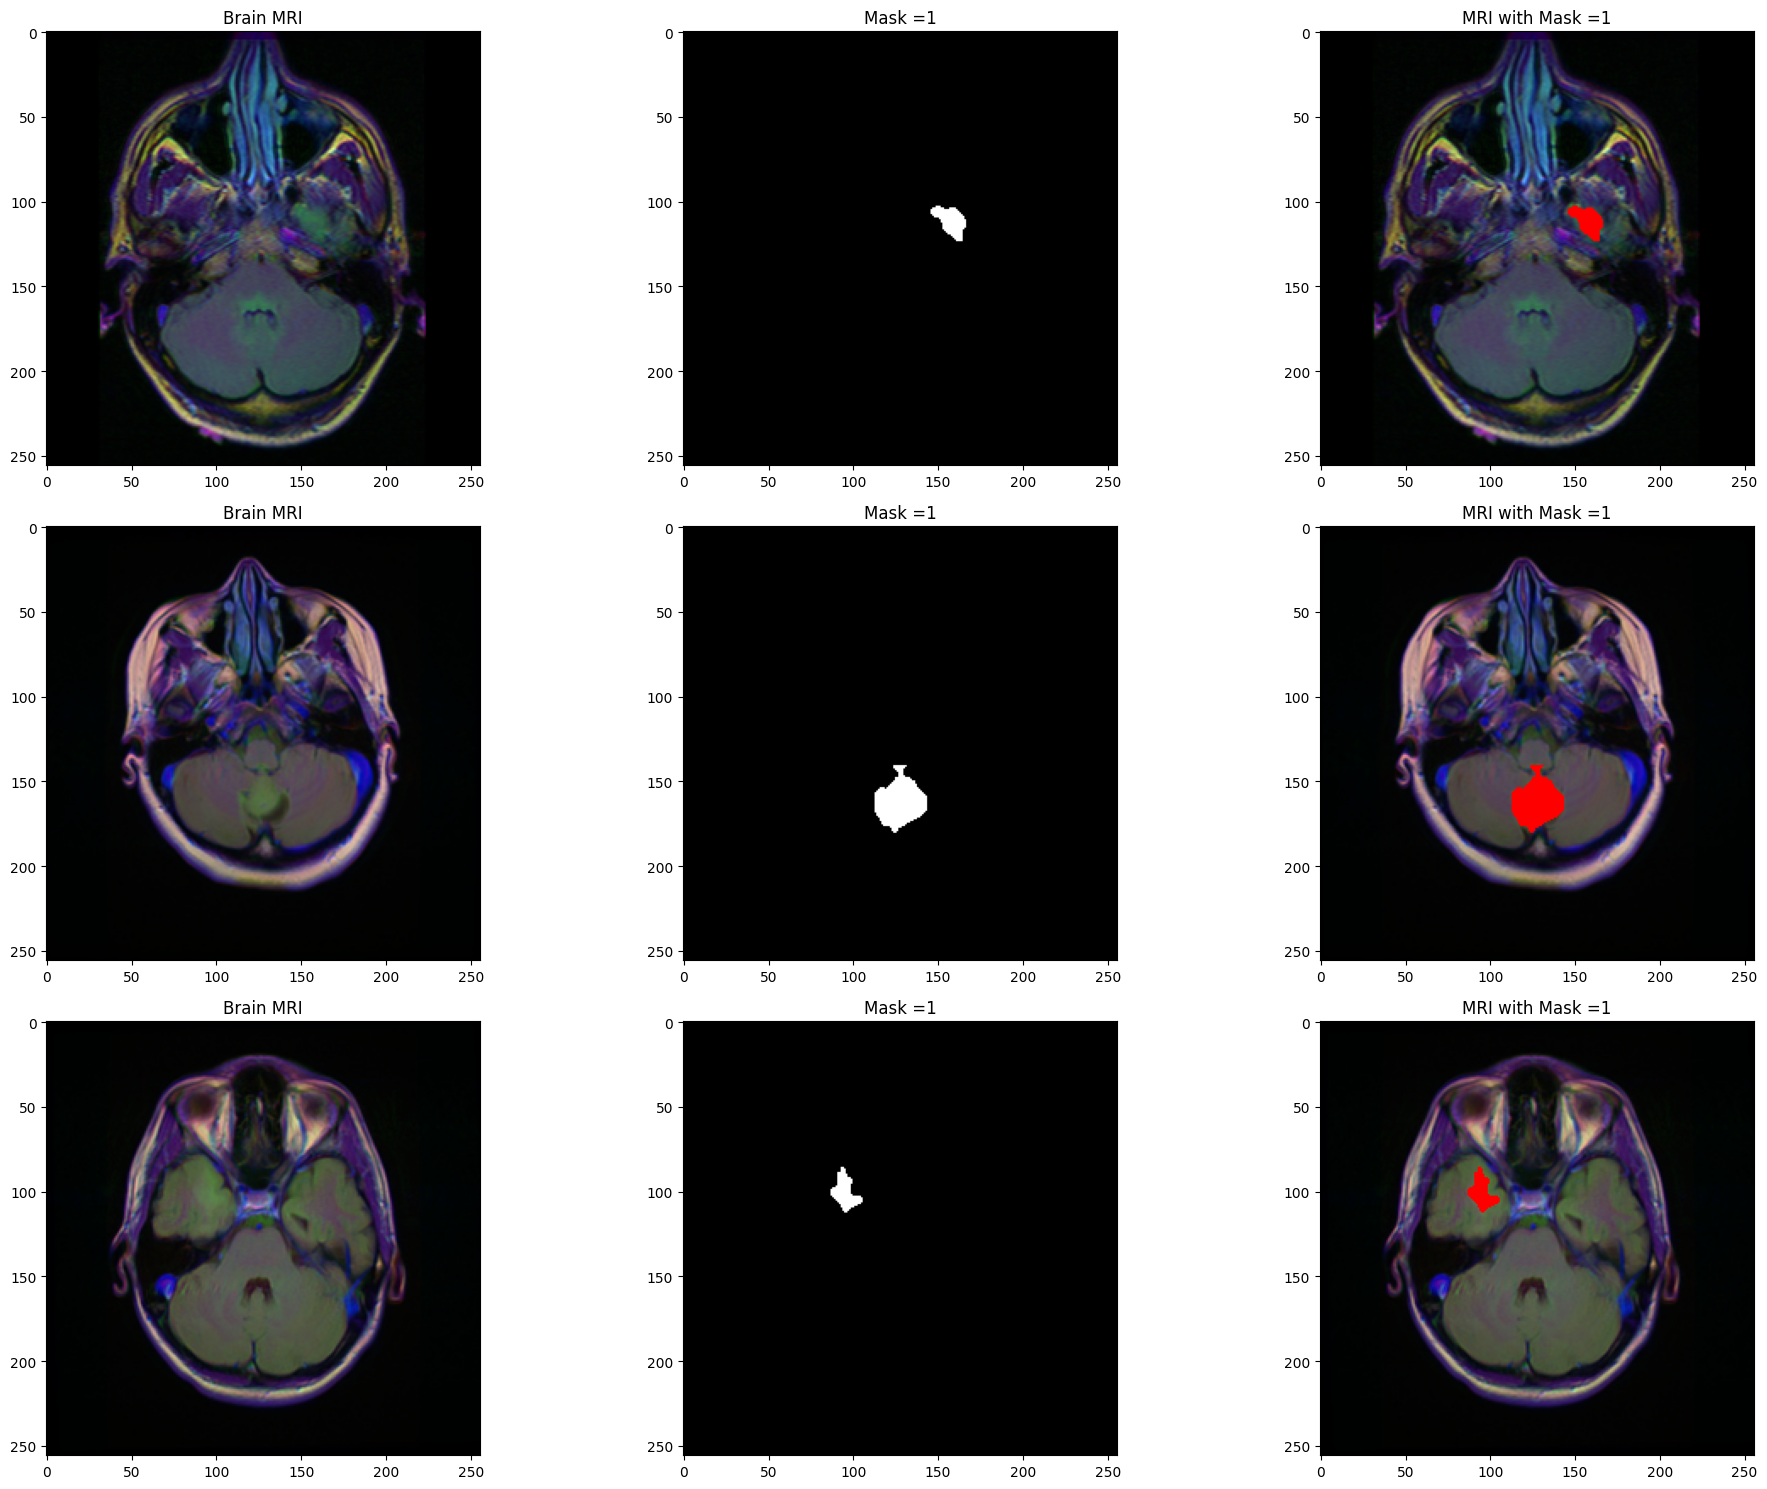

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,15))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "img_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(mri_train, 32,
                                train_generator_args,
                                target_size=(256, 256))
    
val_gen = train_generator(mri_val, 32,
                                dict(),
                                target_size=(256, 256))

In [ ]:
# def unet(pretrained_weights = None,input_size = (256,256,3)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     bn_1 = BatchNormalization(axis=3)(conv1)
#     act_1 = Activation('relu')(bn_1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     bn_2 = BatchNormalization(axis=3)(conv2)
#     act_2 = Activation('relu')(bn_2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     bn_3 = BatchNormalization(axis=3)(conv3)
#     act_3 = Activation('relu')(bn_3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     bn_4 = BatchNormalization(axis=3)(conv4)
#     act_4 = Activation('relu')(bn_4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     bn_5 = BatchNormalization(axis=3)(conv5)
#     act_5 = Activation('relu')(bn_5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
#     merge6 = concatenate([conv4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
#     bn_6 = BatchNormalization(axis=3)(conv6)
#     act_6 = Activation('relu')(bn_6)
    
#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
#     bn_7 = BatchNormalization(axis=3)(conv7)
#     act_7 = Activation('relu')(bn_7)

    
#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
#     bn_8 = BatchNormalization(axis=3)(conv8)
#     act_8 = Activation('relu')(bn_8)
    
#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     bn_9 = BatchNormalization(axis=3)(conv9)
#     act_9 = Activation('relu')(bn_9)
    
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

#     model = model = Model(inputs=[inputs] , outputs = [conv10])    
#     return model

In [ ]:
def unet_conv2dt(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2DTranspose(512, 2, strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')((act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2,2),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')((act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2DTranspose(128, 2, strides=(2,2),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')((act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2,2),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')((act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [ ]:
# model = unet()
# model.summary()

In [ ]:
model = unet_conv2dt()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

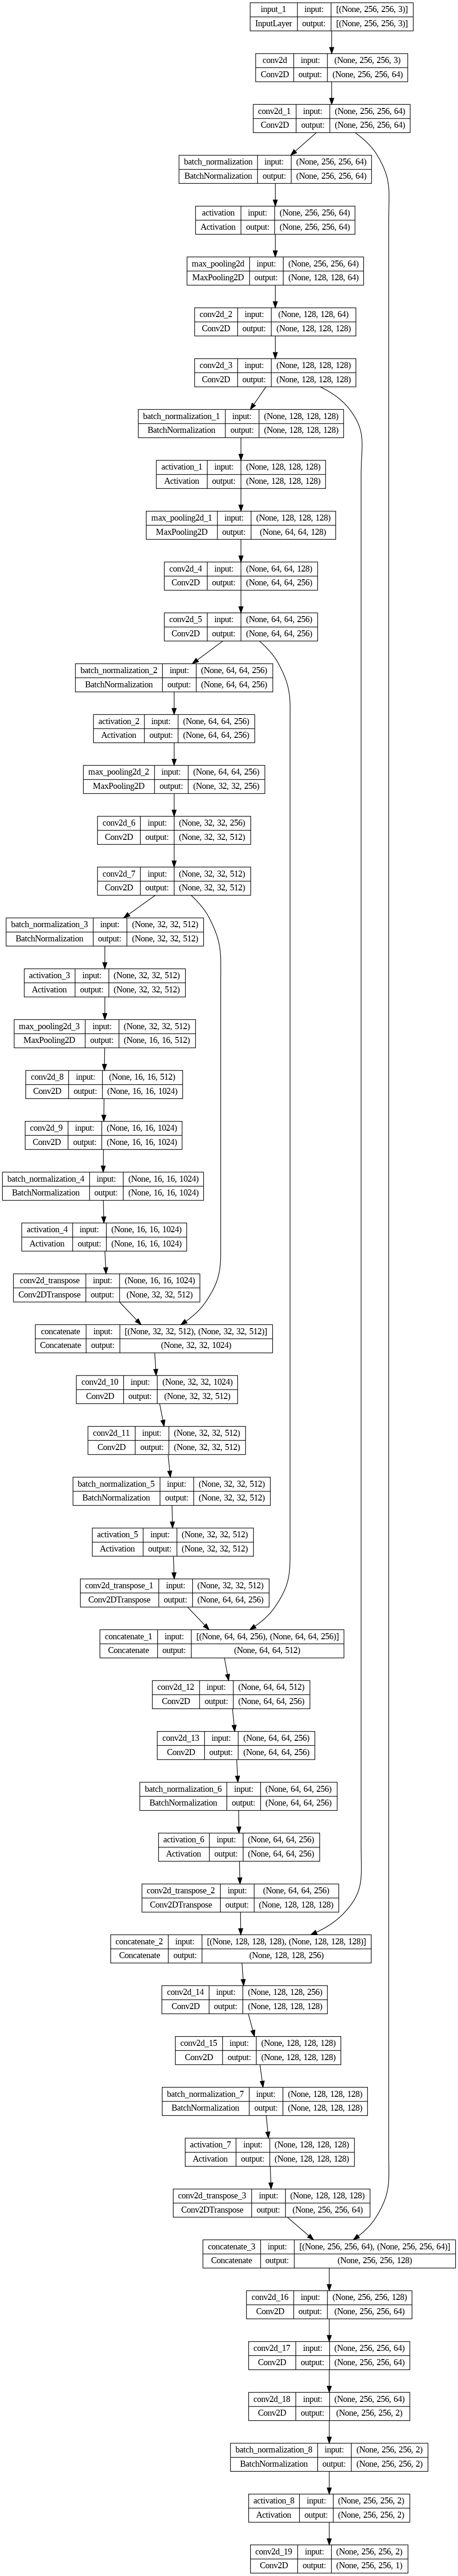

In [ ]:
plot_model(model, to_file='unet_model.png', show_shapes=True)
Image("unet_model.png")

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_iou', min_delta=0.00001, patience=6, 
                           mode='auto', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)

In [ ]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
EPOCH = 100
learning_rate = 1e-3

In [ ]:
# model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
#               loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
model.compile(optimizer=Adam(learning_rate=1e-3, amsgrad=False),loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [ ]:
history = model.fit(train_gen,steps_per_epoch=len(mri_train)/32,
                    epochs=EPOCH ,validation_data=val_gen,validation_steps=len(mri_val) / 32,
                    callbacks=[model_checkpoint])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
15/88 [====>.........................] - ETA: 4:48:12 - loss: 0.9697 - binary_accuracy: 0.8172 - iou: 0.0155 - dice_coef: 0.0303

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("UNet-seg-model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou']);
plt.plot(history.history['val_iou']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(mri_test.img_path)
test_mask = list(mri_test.mask_path)

In [ ]:
def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.img_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'img_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
df_pred = prediction(mri_test, model)
df_pred

In [ ]:
df_pred = mri_test.merge(df_pred, on='img_path')
df_pred.head()

In [ ]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground Truth')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.img_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        
        count +=1
    if (count==3):
        break

fig.tight_layout()